In [124]:
# Import libraries
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
from keras.utils import np_utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [125]:
# Keep reproducible results
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [126]:
# Input preprocessing
train = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_label = train.iloc[:, :1]
train_data = train.iloc[:, 1:]

In [127]:
X_train = train_data.values.astype('float32')
size = X_train.shape[1]
width = np.sqrt(size).astype('int32')
height = width
X_train = X_train.reshape(X_train.shape[0], width, height, 1)
print('shape of train X: {}'.format(X_train.shape))
Y_train = train_label.values.astype('int32')
Y_train = np_utils.to_categorical(Y_train)
print('shape of train Y: {}'.format(Y_train.shape))
X_test = test_data.values.astype('float32')
X_test = X_test.reshape(X_test.shape[0], width, height, 1)
print('shape of test X: {}'.format(X_test.shape))

shape of train X: (42000, 28, 28, 1)
shape of train Y: (42000, 10)
shape of test X: (28000, 28, 28, 1)


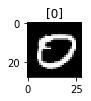

In [128]:
# Verify data
index = np.random.randint(0, X_train.shape[0])
plt.figure(figsize=(1, 1))
plt.imshow(X_train[index].reshape(width, height), cmap=plt.get_cmap('gray'))
title = [i for i, v in enumerate(Y_train[index]) if int(v) == 1]
plt.title(title)

In [129]:
# Normalizing input
validation_split = 0.05
train_size = int(X_train.shape[0]*(1-validation_split))
def normalize(X):
    return X/255-np.mean(X_train[:train_size]/255, axis=0)
X_train_normalized = normalize(X_train)
X_test_normalized = normalize(X_test)

In [130]:
print(np.mean(X_train_normalized, axis=0).shape)
print(np.max(np.mean(X_train_normalized, axis=0)))
print(np.max(np.mean(X_test_normalized, axis=0)))

(28, 28, 1)
0.00105774
0.0113666


In [131]:
# Build model
model = Sequential()
model.add(Conv2D(8, (3, 3), activation='relu', input_shape=X_train_normalized.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 8)         0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 11, 11, 16)        1168      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
__________

In [132]:
# Train model
start = time.time()
history = model.fit(X_train_normalized, Y_train, batch_size=32, epochs=20, verbose=1, 
          validation_split=validation_split, shuffle=True)
end = time.time()
print('Takes {}s'.format(end-start))

Train on 39900 samples, validate on 2100 samples
Epoch 1/20
39900/39900 [==============================] - 26s - loss: 0.3148 - acc: 0.9005 - val_loss: 0.1066 - val_acc: 0.9657
Epoch 2/20
39900/39900 [==============================] - 22s - loss: 0.1218 - acc: 0.9613 - val_loss: 0.0548 - val_acc: 0.9829
Epoch 3/20
39900/39900 [==============================] - 23s - loss: 0.0972 - acc: 0.9684 - val_loss: 0.0529 - val_acc: 0.9814
Epoch 4/20
39900/39900 [==============================] - 23s - loss: 0.0806 - acc: 0.9753 - val_loss: 0.0531 - val_acc: 0.9814
Epoch 5/20
39900/39900 [==============================] - 22s - loss: 0.0731 - acc: 0.9765 - val_loss: 0.0455 - val_acc: 0.9843
Epoch 6/20
39900/39900 [==============================] - 24s - loss: 0.0671 - acc: 0.9793 - val_loss: 0.0418 - val_acc: 0.9867
Epoch 7/20
39900/39900 [==============================] - 26s - loss: 0.0642 - acc: 0.9800 - val_loss: 0.0430 - val_acc: 0.9857
Epoch 8/20
39900/39900 [==============================]

In [149]:
X_validation = X_train_normalized[train_size:]
Y_validation = Y_train[train_size:]
print model.evaluate(X_validation, Y_validation, batch_size=X_validation.shape[0])

2100/2100 [==============================] - 0s
[0.034018129110336304, 0.99000000953674316]


['acc', 'loss', 'val_acc', 'val_loss']


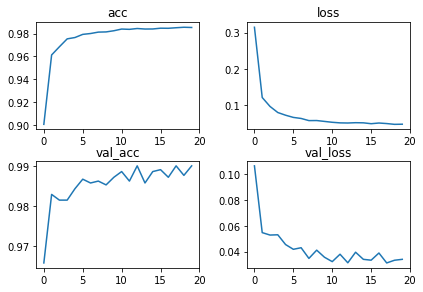

In [148]:
# Plot trends to decide action for improvement
print(history.history.keys())
history_data = history.history
fig, axes = plt.subplots(2, 2)
fig.tight_layout()
for i, key in enumerate(history_data.keys()):
    ax = plt.subplot(2, 2, i+1)
    plt.plot(history_data[key])
    ax.set_title(key)

Accuracy is slowly improving and loss is decreasing, so try to train for longer.

In [150]:
histories = []
histories.append(history)

In [152]:
# Train for longer
start = time.time()
history = model.fit(X_train_normalized, Y_train, batch_size=32, epochs=20, verbose=1, 
          validation_split=validation_split, shuffle=True)
end = time.time()
print('Takes {}s'.format(end-start))

Train on 39900 samples, validate on 2100 samples
Epoch 1/20
39900/39900 [==============================] - 24s - loss: 0.0518 - acc: 0.9842 - val_loss: 0.0409 - val_acc: 0.9867
Epoch 2/20
39900/39900 [==============================] - 23s - loss: 0.0468 - acc: 0.9858 - val_loss: 0.0382 - val_acc: 0.9890
Epoch 3/20
39900/39900 [==============================] - 23s - loss: 0.0480 - acc: 0.9855 - val_loss: 0.0409 - val_acc: 0.9890
Epoch 4/20
39900/39900 [==============================] - 22s - loss: 0.0462 - acc: 0.9857 - val_loss: 0.0359 - val_acc: 0.9881
Epoch 5/20
39900/39900 [==============================] - 22s - loss: 0.0484 - acc: 0.9855 - val_loss: 0.0362 - val_acc: 0.9876
Epoch 6/20
39900/39900 [==============================] - 23s - loss: 0.0495 - acc: 0.9857 - val_loss: 0.0371 - val_acc: 0.9895
Epoch 7/20
39900/39900 [==============================] - 25s - loss: 0.0500 - acc: 0.9854 - val_loss: 0.0349 - val_acc: 0.9924
Epoch 8/20
39900/39900 [==============================]

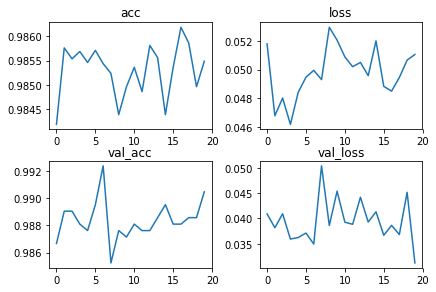

In [153]:
histories.append(history)
history_data = history.history
fig, axes = plt.subplots(2, 2)
fig.tight_layout()
for i, key in enumerate(history_data.keys()):
    ax = plt.subplot(2, 2, i+1)
    plt.plot(history_data[key])
    ax.set_title(key)

In [154]:
# Save model
from keras.models import load_model

model.save('digit_recognizer.h5')
del model

model = load_model('digit_recognizer.h5')
X_validation = X_train_normalized[train_size:]
Y_validation = Y_train[train_size:]
print model.evaluate(X_validation, Y_validation, batch_size=X_validation.shape[0])

2100/2100 [==============================] - 0s
[0.031204797327518463, 0.99047619104385376]


Final validation accuracy is ~99%.

In [155]:
# Make predictions for Kaggle submission
preds = model.predict_classes(X_test_normalized, verbose=1)
pd.DataFrame({
    'ImageId': list(range(1, len(preds)+1)),
    'Label': preds}).to_csv('submission.csv', index=False, header=True)

27872/28000 [============================>.] - ETA: 0s

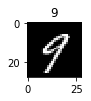

In [163]:
# Check
index = np.random.randint(len(X_test))
plt.figure(figsize=(1,1))
plt.imshow(X_test[index].reshape(width, height), cmap=plt.get_cmap('gray'))
plt.title(preds[index])